# Transform NorESM data to DGGS

## Context

### Purpose

The goal is to experiment how to transform NorESM data into DGGS (healpix grid).

```{warning}
**This notebook does not work yet**. We encountered issues when transforming NorESM data into the DGGS format.
In addition, this FAIR2Adapt case study will likely require different types of interpolation, as bilinear interpolation is not suitable for all variables. For instance, conservative interpolation is currently being developed.
```

### Description

In this notebook, we will:
- Open online NorESM data 
- Transform one variable (TREFHT) into DGGS Healpix
- Save the transformed data in Zarr

## Contributions

### Notebook


- Even Moa Myklebust, Simula Research Laboratory (Norway) (author), @evenmm
- Anne Fouilloux, Simula Research Laboratory (Norway) (reviewer), @annefou

## Bibliography and other interesting resources

- [The Norwegian Earth System Model (NorESM)](https://noresm-docs.readthedocs.io/en/latest/)
- NorESM dataset used in this notebook, [10.11582/2024.00093](https://doi.org/10.11582/2024.00093)

In [ ]:
# Install dggs library for regridding
!pip install git+https://github.com/IAOCEA/xarray-healpy.git git+https://github.com/xarray-contrib/xdggs.git cmcrameri

## Import Libraries

In [2]:
import s3fs # For accessing file storage at Amazon S3
import xarray as xr # N-dimensional arrays with dimension, coordinate and attribute labels
from xarray_healpy import HealpyGridInfo, HealpyRegridder
import numpy as np

xr.set_options(keep_attrs=True)

## Open file with Xarray
- The file is on the cloud (accessible to everyone)

In [ ]:
# Extract file from S3
client_kwargs={'endpoint_url': 'https://pangeo-eosc-minioapi.vm.fedcloud.eu/'}
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=client_kwargs)

filename_atmosphere = "s3://afouilloux-fair2adapt/10.11582_2024.00093/N1850_f19_tn14_20190722/atm/hist/N1850_f19_tn14_20190722.cam.h0.1801-01.nc"

In [ ]:
# Opening the atmosphere ds typically takes a few minutes
atmosphere_ds = xr.open_dataset(s3.open(filename_atmosphere))
atmosphere_ds

## Save a few variables locally

In [ ]:
atmosphere_ds[["SST", "TREFHT"]].to_zarr("small_N1850_f19_tn14_20190722.cam.h0.1801-01.zarr")

### Open local file

In [3]:
ds = xr.open_zarr("small_N1850_f19_tn14_20190722.cam.h0.1801-01.zarr")
ds

<xarray.Dataset> Size: 113kB
Dimensions:  (time: 1, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 8B 1801-02-01 00:00:00
Data variables:
    SST      (time, lat, lon) float32 55kB dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    TREFHT   (time, lat, lon) float32 55kB dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    case:              N1850_f19_tn14_20190722
    host:              
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    logname:           olivie
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  month_1
    topography_file:   /cluster/shared/noresm/inputdata/atm/cam/topo/fv_1.9x2...

## Quick visualization of reference height temperature (TREFHT)

## Standardize coordinate names

In [4]:
ds["lat"] = ds["lat"].assign_attrs(standard_name="latitude")
ds["lon"] = ds["lon"].assign_attrs(standard_name="longitude")
ds = ds.rename_vars({"lat": "latitude", "lon": "longitude"})
ds = ds.merge(ds[["latitude", "longitude"]].compute() )
ds

<xarray.Dataset> Size: 113kB
Dimensions:    (time: 1, lat: 96, lon: 144)
Coordinates:
  * latitude   (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time       (time) object 8B 1801-02-01 00:00:00
Dimensions without coordinates: lat, lon
Data variables:
    SST        (time, lat, lon) float32 55kB dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    TREFHT     (time, lat, lon) float32 55kB dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    case:              N1850_f19_tn14_20190722
    host:              
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    logname:           olivie
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  month_1
    topography_file:   /cluster/shared/noresm/inputdata/atm/cam/topo/fv_1.9x2...

## Select variable of interest

In [5]:
# Regrid temperature to DGGS 
level = 4                       # Healpix level
nside = level**2                # Each side of the original 12 faces in Healpix is divided into nside parts 
number_of_cells = 12*nside**2   # The resulting total number of cells

min_vertices = 1                # Minimum number of vertices for a valid transcription for regridding.
                                # 1 is the most liberal, meaning that only one is needed 

print("Level:", level)
print("nside:", nside)
print("Number of cells:", number_of_cells)

Level: 4
nside: 16
Number of cells: 3072


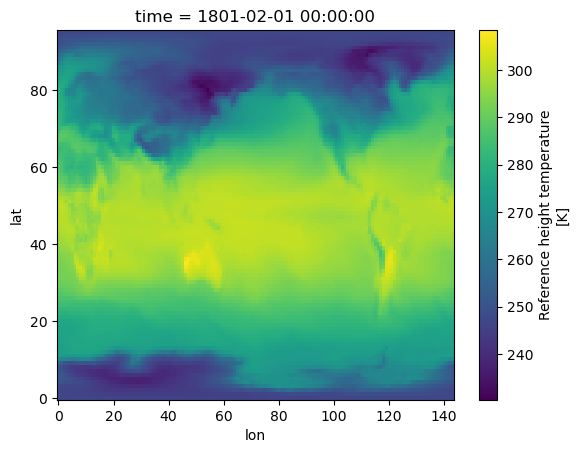

In [6]:
# Plot reference height temperature (TREFHT)
ds.TREFHT.isel(time=0).plot()

In [7]:
def center_longitude(ds, center):
    if center == 0:
        centered = (ds.longitude + 180) % 360 - 180
    else:
        centered = (ds.longitude - 180) % 360 + 180

    return ds.assign_coords(longitude=centered)

In [8]:
%%time
# Define the target Healpix grid information
grid = HealpyGridInfo(level=level)
target_grid = grid.target_grid(ds).pipe(center_longitude, 0)
target_grid

CPU times: user 811 ms, sys: 48 ms, total: 859 ms
Wall time: 855 ms


<xarray.Dataset> Size: 71kB
Dimensions:     (cells: 2961)
Coordinates:
    cell_ids    (cells) uint64 24kB 0 1 2 3 4 5 ... 3067 3068 3069 3070 3071
    latitude    (cells) float64 24kB 2.388 4.78 4.78 ... -4.78 -4.78 -2.388
    longitude   (cells) float64 24kB 45.0 47.81 42.19 ... -42.19 -47.81 -45.0
    resolution  float64 8B 0.06396
Dimensions without coordinates: cells
Data variables:
    *empty*
Attributes:
    grid_type:  healpix
    level:      4
    nside:      16
    lat:        0
    lon:        0
    rot_lat:    0
    rot_lon:    0

In [ ]:
%%time
min_vertices = 1
# Compute the interpolation weights for regridding the diff data
regridder = HealpyRegridder(
    ds[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={},
)
regridder

In [ ]:
%%time
# Perform the regridding operation using the computed interpolation weights.
regridded = regridder.regrid_ds(ds).pipe(xdggs.decode)